In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:
molecule = "H2"
symbols = qml.qchem.mol_data("H2")[0]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

symbols, coordinates

(['H', 'H'],
 tensor([ 0.    ,  0.    , -0.6614,  0.    ,  0.    ,  0.6614], requires_grad=True))

In [3]:
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is    (-0.2427450126094144) [Z2]
+ (-0.2427450126094144) [Z3]
+ (-0.042072551947439224) [I0]
+ (0.1777135822909176) [Z0]
+ (0.1777135822909176) [Z1]
+ (0.12293330449299361) [Z0 Z2]
+ (0.12293330449299361) [Z1 Z3]
+ (0.16768338855601356) [Z0 Z3]
+ (0.16768338855601356) [Z1 Z2]
+ (0.17059759276836803) [Z0 Z1]
+ (0.1762766139418181) [Z2 Z3]
+ (-0.044750084063019925) [Y0 Y1 X2 X3]
+ (-0.044750084063019925) [X0 X1 Y2 Y3]
+ (0.044750084063019925) [Y0 X1 X2 Y3]
+ (0.044750084063019925) [X0 Y1 Y2 X3]


In [4]:
dev = qml.device("lightning.qubit", wires=qubits)

electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [5]:
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])

In [6]:
def hartree_to_ev(hartree):
  return hartree * 27.2114

In [7]:
@qml.qnode(dev, interface="autograd")
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)

In [8]:
opt = qml.NesterovMomentumOptimizer(stepsize=0.05)
theta = np.array(0.0, requires_grad=True)

In [9]:
# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha or {hartree_to_ev(energy[-1]):.8f} eV")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.11891728 Ha
Step = 1,  Energy = -1.12159838 Ha
Step = 2,  Energy = -1.12485312 Ha
Step = 3,  Energy = -1.12816669 Ha
Step = 4,  Energy = -1.13112582 Ha
Step = 5,  Energy = -1.13346087 Ha
Step = 6,  Energy = -1.13505482 Ha
Step = 7,  Energy = -1.13592520 Ha
Step = 8,  Energy = -1.13618888 Ha
Step = 9,  Energy = -1.13601941 Ha
Step = 10,  Energy = -1.13560608 Ha
Step = 11,  Energy = -1.13512086 Ha
Step = 12,  Energy = -1.13469657 Ha
Step = 13,  Energy = -1.13441686 Ha
Step = 14,  Energy = -1.13431642 Ha
Step = 15,  Energy = -1.13438883 Ha
Step = 16,  Energy = -1.13459872 Ha
Step = 17,  Energy = -1.13489526 Ha
Step = 18,  Energy = -1.13522458 Ha
Step = 19,  Energy = -1.13553937 Ha
Step = 20,  Energy = -1.13580498 Ha
Step = 21,  Energy = -1.13600191 Ha
Step = 22,  Energy = -1.13612517 Ha
Step = 23,  Energy = -1.13618155 Ha
Step = 24,  Energy = -1.13618566 Ha
Step = 25,  Energy = -1.13615574 Ha
Step = 26,  Energy = -1.13610996 Ha
Step = 27,  Energy = -1.13606365 Ha
St

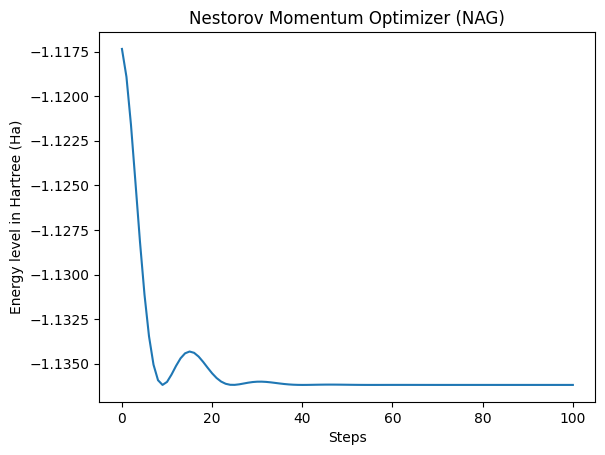

In [12]:
import matplotlib.pyplot as plt

# Create a figure object
fig = plt.figure()

# Create an axes object
ax = fig.add_subplot(1, 1, 1)

x = np.arange(0, 101)
# Plot the data on the axes object
ax.plot(x, energy)

# Set the title and labels of the graph
plt.title("Nestorov Momentum Optimizer (NAG)")
plt.ylabel("Energy level in Hartree (Ha)")
plt.xlabel("Steps")

# Show the graph
plt.show()

In [11]:
np.save('3-NAG.npy', energy)